In [2]:
!pip install -e ./gym/[all]

Obtaining file:///D:/Usuarios/ronie/pucp/artificial-intelligence/ta/gym
  Using cached https://files.pythonhosted.org/packages/98/c2/ab05b5329dc4416b5ee5530f0625a79c394a3e3c10abe0812b9345256451/box2d-py-2.3.8.tar.gz
  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  Using cached https://files.pythonhosted.org/packages/c8/22/9460e311f340cb62d26a38c419b1381b8593b0bb6b5d1f056938b086d362/lockfile-0.12.2-py2.py3-none-any.whl
  Complete output from command D:\Programas\Anaconda\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\OSCARA~1\\AppData\\Local\\Temp\\pip-install-05_grqpk\\box2d-py\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\OSCARA~1\AppData\Local\Temp\pip-wheel-tcreaxh5 --python-tag cp37:
  Using setuptools (version 40.8.0).
  running bdist_wheel
  ru

  Failed building wheel for box2d-py
  Failed building wheel for mujoco-py
Command "D:\Programas\Anaconda\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\OSCARA~1\\AppData\\Local\\Temp\\pip-install-05_grqpk\\box2d-py\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\OSCARA~1\AppData\Local\Temp\pip-record-xxrzqh19\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\OSCARA~1\AppData\Local\Temp\pip-install-05_grqpk\box2d-py\


In [3]:
!pip show gym

Name: gym
Version: 0.17.2
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: d:\usuarios\ronie\pucp\artificial-intelligence\ta\gym
Requires: scipy, numpy, pyglet, cloudpickle
Required-by: 


In [18]:
import gym
from gym import envs

In [20]:
env = gym.make('BipedalWalkerHardcore-v3')
env.reset()
for _ in range(500):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=600, fc1_units=300):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

        self.bn1 = nn.BatchNorm1d(fc_units)
        self.bn2 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu((self.bn1(self.fc1(state))))
        x = F.relu((self.bn2(self.fc2(x))))
        return F.torch.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=600, fcs2_units=300, fca1_units=300):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu((self.bn1(self.fcs1(state))))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)

In [2]:
import numpy as np
import copy
import random
from collections import namedtuple, deque

#from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = 1000000      # replay buffer size
BATCH_SIZE = 100           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR_ACTOR = 0.0001          # learning rate of the actor
LR_CRITIC = 0.001          # learning rate of the critic
WEIGHT_DECAY = 0.001       # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
import gym
import torch
import numpy as np
#from ddpg_agent import Agent
import matplotlib.pyplot as plt

env = gym.make('BipedalWalkerHardcore-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)


def ddpg(episodes, step, pretrained, noise):

    if pretrained:
        agent.actor_local.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))

    reward_list = []

    for i in range(episodes):

        state = env.reset()
        score = 0

        for t in range(step):

            env.render()

            action = agent.act(state, noise)
            next_state, reward, done, info = env.step(action[0])
            agent.step(state, action, reward, next_state, done)
            state = next_state.squeeze()
            score += reward

            if done:
                print('Reward: {} | Episode: {}/{}'.format(score, i, episodes))
                break

        reward_list.append(score)

        if score >= 270:
            print('Task Solved')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')
            break

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
    torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')

    print('Training saved')
    return reward_list


scores = ddpg(episodes=10000, step=2000, pretrained=1, noise=0)
env.close()

d:\usuarios\ronie\pucp\artificial-intelligence\ta\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Reward: -90.3329851447036 | Episode: 0/10000
Reward: -106.92468336468129 | Episode: 1/10000
Reward: -222.33770491632498 | Episode: 2/10000
Reward: -258.55928304501225 | Episode: 3/10000
Reward: -137.23068711016515 | Episode: 4/10000
Reward: -122.96772842761999 | Episode: 5/10000
Reward: -123.07054171762864 | Episode: 6/10000
Reward: -136.87464801589027 | Episode: 7/10000
Reward: -169.28687802073395 | Episode: 8/10000
Reward: -174.94832980638108 | Episode: 9/10000
Reward: -184.01246883311848 | Episode: 10/10000
Reward: -153.35644504203333 | Episode: 11/10000
Reward: -159.07482648476696 | Episode: 12/10000
Reward: -94.03207355808838 | Episode: 13/10000
Reward: -152.49449608057216 | Episode: 14/10000
Reward: -98.77386403830815 | Episode: 15/10000
Reward: -120.70228136485571 | Episode: 16/10000
Reward: -125.21897598160248 | Episode: 17/10000
Reward: -105.98907562898286 | Episode: 18/10000
Reward: -91.9377971313956 | Episode: 19/10000
Reward: -129.94743340811797 | Episode: 20/10000
Reward: 

Reward: -126.778081457611 | Episode: 171/10000
Reward: -53.105099912109004 | Episode: 172/10000
Reward: -100.06727014532066 | Episode: 173/10000
Reward: -87.12206161360427 | Episode: 174/10000
Reward: -59.37225453770414 | Episode: 175/10000
Reward: -57.41934246147129 | Episode: 176/10000
Reward: -94.6787164798739 | Episode: 177/10000
Reward: -143.72696061969637 | Episode: 178/10000
Reward: -112.27188699009518 | Episode: 179/10000
Reward: -103.88879099120014 | Episode: 180/10000
Reward: -181.9243439366199 | Episode: 181/10000
Reward: -113.13924129723199 | Episode: 182/10000
Reward: -76.16065350072893 | Episode: 183/10000
Reward: -60.82815457348122 | Episode: 184/10000
Reward: -74.13401008124771 | Episode: 185/10000
Reward: -81.7762408789657 | Episode: 186/10000
Reward: -106.25790348416908 | Episode: 187/10000
Reward: -86.17737996190739 | Episode: 188/10000
Reward: -79.3044482392477 | Episode: 189/10000
Reward: -110.48552186345248 | Episode: 190/10000
Reward: -87.16748489465192 | Episode

Reward: -88.00617859677459 | Episode: 341/10000
Reward: -100.61450058152123 | Episode: 342/10000
Reward: -101.86474853681834 | Episode: 343/10000
Reward: -97.62870710548573 | Episode: 344/10000
Reward: -93.17927273374032 | Episode: 345/10000
Reward: -72.28951990174083 | Episode: 346/10000
Reward: -63.96942482620539 | Episode: 347/10000
Reward: -89.60757825414153 | Episode: 348/10000
Reward: -83.30978913663948 | Episode: 349/10000
Reward: -87.31584943650041 | Episode: 350/10000
Reward: -82.2262531690423 | Episode: 351/10000
Reward: -189.16555270188695 | Episode: 352/10000
Reward: -67.50328728592379 | Episode: 353/10000
Reward: -95.82700597500553 | Episode: 354/10000
Reward: -61.313662847966896 | Episode: 355/10000
Reward: -84.62971462911213 | Episode: 356/10000
Reward: -112.2641465907165 | Episode: 357/10000
Reward: -96.303257158362 | Episode: 358/10000
Reward: -80.11630580781943 | Episode: 359/10000
Reward: -86.74489465865804 | Episode: 360/10000
Reward: -81.7789071444571 | Episode: 36

Reward: -83.04533713267247 | Episode: 511/10000
Reward: -60.27749108691769 | Episode: 512/10000
Reward: -63.911918236331715 | Episode: 513/10000
Reward: -58.817625112943354 | Episode: 514/10000
Reward: -103.76024303913738 | Episode: 515/10000
Reward: -38.56224656720772 | Episode: 516/10000
Reward: -23.41929616691388 | Episode: 517/10000
Reward: -49.97234082202554 | Episode: 518/10000
Reward: -76.89664394372858 | Episode: 519/10000
Reward: -86.86578594435379 | Episode: 520/10000
Reward: -96.39887601928692 | Episode: 521/10000
Reward: -90.78491346856191 | Episode: 522/10000
Reward: -106.15024374587709 | Episode: 523/10000
Reward: -96.58088397069399 | Episode: 524/10000
Reward: -89.03317370007436 | Episode: 525/10000
Reward: -113.49226979667012 | Episode: 526/10000
Reward: -90.86617485053713 | Episode: 527/10000
Reward: -100.99439367529936 | Episode: 528/10000
Reward: -86.70529876988303 | Episode: 529/10000
Reward: -55.426810348893206 | Episode: 530/10000
Reward: -78.06221864310278 | Epis

Reward: -17.17168546141761 | Episode: 681/10000
Reward: -101.62191237325283 | Episode: 682/10000
Reward: -81.5238389100923 | Episode: 683/10000
Reward: -70.52436837163444 | Episode: 684/10000
Reward: -63.41400073647127 | Episode: 685/10000
Reward: -95.88956969430004 | Episode: 686/10000
Reward: -65.59592138554342 | Episode: 687/10000
Reward: -68.70591590556754 | Episode: 688/10000
Reward: -84.96373908613175 | Episode: 689/10000
Reward: -98.8481003368691 | Episode: 690/10000
Reward: -91.22270350466879 | Episode: 691/10000
Reward: -68.60145188694813 | Episode: 692/10000
Reward: -84.64200863619304 | Episode: 693/10000
Reward: -74.6888865142884 | Episode: 694/10000
Reward: -39.23831189362781 | Episode: 695/10000
Reward: -95.28852290516595 | Episode: 696/10000
Reward: -109.30418382654214 | Episode: 697/10000
Reward: -78.93602662151802 | Episode: 698/10000
Reward: -42.026719150671774 | Episode: 699/10000
Reward: -104.90346380305911 | Episode: 700/10000
Reward: -98.31976091230537 | Episode: 7

Reward: -100.90058066428826 | Episode: 851/10000
Reward: -88.5377331234645 | Episode: 852/10000
Reward: -60.728707106776426 | Episode: 853/10000
Reward: -101.32980476975565 | Episode: 854/10000
Reward: -82.83645703014015 | Episode: 855/10000
Reward: -103.98089187838262 | Episode: 856/10000
Reward: -65.27507428630437 | Episode: 857/10000
Reward: -101.61446656720821 | Episode: 858/10000
Reward: -91.88001270953069 | Episode: 859/10000
Reward: -99.08091859499645 | Episode: 860/10000
Reward: -98.71908652411463 | Episode: 861/10000
Reward: -72.0985368885373 | Episode: 862/10000
Reward: -92.49912303493979 | Episode: 863/10000
Reward: -73.87630000662087 | Episode: 864/10000
Reward: -65.37452118097619 | Episode: 865/10000
Reward: -79.2801294565002 | Episode: 866/10000
Reward: -84.77867904831352 | Episode: 867/10000
Reward: -74.71241942193174 | Episode: 868/10000
Reward: -74.15184993330172 | Episode: 869/10000
Reward: -79.0715195759673 | Episode: 870/10000
Reward: -86.7833384694724 | Episode: 87

Reward: -100.61959661094099 | Episode: 1021/10000
Reward: -100.16445472186493 | Episode: 1022/10000
Reward: -99.35069587745642 | Episode: 1023/10000
Reward: -97.41750172066129 | Episode: 1024/10000
Reward: -94.30245381978774 | Episode: 1025/10000
Reward: -108.30521701392655 | Episode: 1026/10000
Reward: -97.48018965068024 | Episode: 1027/10000
Reward: -56.83863488551477 | Episode: 1028/10000
Reward: -62.27056321958078 | Episode: 1029/10000
Reward: -104.03807334629012 | Episode: 1030/10000
Reward: -102.88171723483192 | Episode: 1031/10000
Reward: -77.72331282928678 | Episode: 1032/10000
Reward: -105.23671724408105 | Episode: 1033/10000
Reward: -72.45880194129609 | Episode: 1034/10000
Reward: -97.88438663822599 | Episode: 1035/10000
Reward: -103.32146621928861 | Episode: 1036/10000
Reward: -99.60596713531855 | Episode: 1037/10000
Reward: -76.25437118348324 | Episode: 1038/10000
Reward: -98.52722074436707 | Episode: 1039/10000
Reward: -95.38140113749044 | Episode: 1040/10000
Reward: -104.

Reward: -92.26284071363199 | Episode: 1187/10000
Reward: -80.55518787959714 | Episode: 1188/10000
Reward: -85.970782786966 | Episode: 1189/10000
Reward: -48.553968219016674 | Episode: 1190/10000
Reward: -87.51353042410251 | Episode: 1191/10000
Reward: -75.00353239956993 | Episode: 1192/10000
Reward: -100.54995200501817 | Episode: 1193/10000
Reward: -99.99464725902335 | Episode: 1194/10000
Reward: -86.06881480874556 | Episode: 1195/10000
Reward: -74.54584240267393 | Episode: 1196/10000
Reward: -82.87767177996597 | Episode: 1197/10000
Reward: -82.5805213070091 | Episode: 1198/10000
Reward: -55.575998340320155 | Episode: 1199/10000
Reward: -92.74870462595796 | Episode: 1200/10000
Reward: -62.094387713912866 | Episode: 1201/10000
Reward: -46.44298176114306 | Episode: 1202/10000
Reward: -86.25853683320122 | Episode: 1203/10000
Reward: -108.5540825772585 | Episode: 1204/10000
Reward: -62.26976108399965 | Episode: 1205/10000
Reward: -58.35757048202865 | Episode: 1206/10000
Reward: -93.3099268

Reward: -82.32348235320059 | Episode: 1353/10000
Reward: -91.03073039753596 | Episode: 1354/10000
Reward: -77.89624472479832 | Episode: 1355/10000
Reward: -97.0354272166652 | Episode: 1356/10000
Reward: -86.42202384082165 | Episode: 1357/10000
Reward: -88.00278810893187 | Episode: 1358/10000
Reward: -94.26642441093301 | Episode: 1359/10000
Reward: -95.36447940374383 | Episode: 1360/10000
Reward: -87.43258186639163 | Episode: 1361/10000
Reward: -40.329983654613265 | Episode: 1362/10000
Reward: -88.01417146712771 | Episode: 1363/10000
Reward: -43.780488710950415 | Episode: 1364/10000
Reward: -82.30986638056052 | Episode: 1365/10000
Reward: -73.06751195021408 | Episode: 1366/10000
Reward: -107.52024825327176 | Episode: 1367/10000
Reward: -90.51871615250782 | Episode: 1368/10000
Reward: -98.75215936243318 | Episode: 1369/10000
Reward: -97.32067893750096 | Episode: 1370/10000
Reward: -88.51921365262973 | Episode: 1371/10000
Reward: -80.46760345137987 | Episode: 1372/10000
Reward: -84.920018

Reward: -100.12796277812062 | Episode: 1519/10000
Reward: -102.07100706280768 | Episode: 1520/10000
Reward: -89.14060239680421 | Episode: 1521/10000
Reward: -238.17715065726438 | Episode: 1522/10000
Reward: -102.77337431896012 | Episode: 1523/10000
Reward: -79.74307821350995 | Episode: 1524/10000
Reward: -96.2915142396018 | Episode: 1525/10000
Reward: -101.44074633047404 | Episode: 1526/10000
Reward: -105.90312089912655 | Episode: 1527/10000
Reward: -103.41479083312551 | Episode: 1528/10000
Reward: -177.78173615186194 | Episode: 1529/10000
Reward: -86.71515578023158 | Episode: 1530/10000
Reward: -101.42695418378835 | Episode: 1531/10000
Reward: -58.132777524813086 | Episode: 1532/10000
Reward: -55.64407039951038 | Episode: 1533/10000
Reward: -103.8368382387391 | Episode: 1534/10000
Reward: -102.39713850177824 | Episode: 1535/10000
Reward: -68.2228334410023 | Episode: 1536/10000
Reward: -99.68495159220882 | Episode: 1537/10000
Reward: -80.87974684077874 | Episode: 1538/10000
Reward: -89

Reward: -105.74943074925679 | Episode: 1684/10000
Reward: -101.59277302060525 | Episode: 1685/10000
Reward: -97.60294256744534 | Episode: 1686/10000
Reward: -77.58319123247648 | Episode: 1687/10000
Reward: -107.21493365033032 | Episode: 1688/10000
Reward: -80.10087548794814 | Episode: 1689/10000
Reward: -74.69066304762413 | Episode: 1690/10000
Reward: -91.8923813985226 | Episode: 1691/10000
Reward: -101.08754358321956 | Episode: 1692/10000
Reward: -109.26327157930037 | Episode: 1693/10000
Reward: -86.18789851644418 | Episode: 1694/10000
Reward: -72.46903021745072 | Episode: 1695/10000
Reward: -100.13613055030133 | Episode: 1696/10000
Reward: -89.95436240537651 | Episode: 1697/10000
Reward: -53.018912399876015 | Episode: 1698/10000
Reward: -100.44661696960762 | Episode: 1699/10000
Reward: -104.37095382889422 | Episode: 1700/10000
Reward: -78.8917717066845 | Episode: 1701/10000
Reward: -68.15874426672794 | Episode: 1702/10000
Reward: -57.851792376690234 | Episode: 1703/10000
Reward: -87.

Reward: -71.8532495852985 | Episode: 1850/10000
Reward: -88.19394514469306 | Episode: 1851/10000
Reward: -216.91341774477502 | Episode: 1852/10000
Reward: -139.20021755590662 | Episode: 1853/10000
Reward: -85.36953283666509 | Episode: 1854/10000
Reward: -98.35162076977268 | Episode: 1855/10000
Reward: -185.8520205373624 | Episode: 1856/10000
Reward: -91.833546239368 | Episode: 1857/10000
Reward: -78.54469388252372 | Episode: 1858/10000
Reward: -76.4769250354804 | Episode: 1859/10000
Reward: -41.887601755049126 | Episode: 1860/10000
Reward: -79.84744636350965 | Episode: 1861/10000
Reward: -76.68598961624215 | Episode: 1862/10000
Reward: -80.9927230534392 | Episode: 1863/10000
Reward: -81.19433492259373 | Episode: 1864/10000
Reward: -76.62408923721624 | Episode: 1865/10000
Reward: -104.80359134080975 | Episode: 1866/10000
Reward: -78.43501206958356 | Episode: 1867/10000
Reward: -221.5779899015147 | Episode: 1868/10000
Reward: -220.71329827817974 | Episode: 1869/10000
Reward: -222.1608347

Reward: -111.96044221616164 | Episode: 2016/10000
Reward: -107.02304603662901 | Episode: 2017/10000
Reward: -83.23199685982615 | Episode: 2018/10000
Reward: -147.53723530298663 | Episode: 2019/10000
Reward: -81.59100466301292 | Episode: 2020/10000
Reward: -51.159643874302446 | Episode: 2021/10000
Reward: -82.04537572178741 | Episode: 2022/10000
Reward: -78.32645262508404 | Episode: 2023/10000
Reward: -91.94168643652488 | Episode: 2024/10000
Reward: -57.57467753886245 | Episode: 2025/10000
Reward: -101.81126931490563 | Episode: 2026/10000
Reward: -49.460019331312466 | Episode: 2027/10000
Reward: -66.10227675608729 | Episode: 2028/10000
Reward: -54.58249392498312 | Episode: 2029/10000
Reward: -63.29834545891236 | Episode: 2030/10000
Reward: -69.60445526815329 | Episode: 2031/10000
Reward: -67.60031662781569 | Episode: 2032/10000
Reward: -82.39652476995461 | Episode: 2033/10000
Reward: -105.41153469369809 | Episode: 2034/10000
Reward: -83.52985334656822 | Episode: 2035/10000
Reward: -53.8

Reward: -94.52260285430589 | Episode: 2183/10000
Reward: -83.15467022137949 | Episode: 2184/10000
Reward: -82.21674003139077 | Episode: 2185/10000
Reward: -87.93389132258545 | Episode: 2186/10000
Reward: -72.03696426270422 | Episode: 2187/10000
Reward: -77.68361542899162 | Episode: 2188/10000
Reward: -23.875974052094534 | Episode: 2189/10000
Reward: -87.31700635246808 | Episode: 2190/10000
Reward: -97.82829955515328 | Episode: 2191/10000
Reward: -78.31158623723772 | Episode: 2192/10000
Reward: -76.42164872062828 | Episode: 2193/10000
Reward: -72.50712878248592 | Episode: 2194/10000
Reward: -81.56044401028629 | Episode: 2195/10000
Reward: -88.10392142932986 | Episode: 2196/10000
Reward: -38.132492826112916 | Episode: 2197/10000
Reward: -99.45932404802616 | Episode: 2198/10000
Reward: -19.37834129823304 | Episode: 2199/10000
Reward: -117.00059812153314 | Episode: 2200/10000
Reward: -85.16834468542287 | Episode: 2201/10000
Reward: -37.85657401314567 | Episode: 2202/10000
Reward: -66.69724

Reward: -46.24156821923129 | Episode: 2349/10000
Reward: -96.0450681144176 | Episode: 2350/10000
Reward: -76.00527268644421 | Episode: 2351/10000
Reward: -39.069903265416336 | Episode: 2352/10000
Reward: -79.1384570939628 | Episode: 2353/10000
Reward: -64.42585919899494 | Episode: 2354/10000
Reward: -36.71006590925361 | Episode: 2355/10000
Reward: -40.30981874967366 | Episode: 2356/10000
Reward: -68.38373320844956 | Episode: 2357/10000
Reward: -103.07501690459438 | Episode: 2358/10000
Reward: -73.60148861102388 | Episode: 2359/10000
Reward: -50.08951799720353 | Episode: 2360/10000
Reward: -85.92116011967137 | Episode: 2361/10000
Reward: -49.954695641845454 | Episode: 2362/10000
Reward: -80.56001312069844 | Episode: 2363/10000
Reward: -97.23654692765015 | Episode: 2364/10000
Reward: -91.09491557322916 | Episode: 2365/10000
Reward: -76.69002375311157 | Episode: 2366/10000
Reward: -107.13841393337647 | Episode: 2367/10000
Reward: -95.20327951621141 | Episode: 2368/10000
Reward: -94.958969

Reward: -51.34326417167313 | Episode: 2516/10000
Reward: -97.9761256287396 | Episode: 2517/10000
Reward: -39.77805388136647 | Episode: 2518/10000
Reward: -87.4800104526162 | Episode: 2519/10000
Reward: -108.45226103021577 | Episode: 2520/10000
Reward: -77.44071905799893 | Episode: 2521/10000
Reward: -90.46342321077951 | Episode: 2522/10000
Reward: -46.25802984695787 | Episode: 2523/10000
Reward: -45.88449362398714 | Episode: 2524/10000
Reward: -71.09636196513165 | Episode: 2525/10000
Reward: -89.26992238536819 | Episode: 2526/10000
Reward: -87.47303422228246 | Episode: 2527/10000
Reward: -111.19453771063002 | Episode: 2528/10000
Reward: -85.64469927102948 | Episode: 2529/10000
Reward: -76.22908027601025 | Episode: 2530/10000
Reward: -48.320696254396836 | Episode: 2531/10000
Reward: -134.21127395118464 | Episode: 2532/10000
Reward: -85.12946602891726 | Episode: 2533/10000
Reward: -89.91469663523138 | Episode: 2534/10000
Reward: -106.4360110539794 | Episode: 2535/10000
Reward: -90.765451

Reward: -77.09900513208514 | Episode: 2682/10000
Reward: -87.0354811726821 | Episode: 2683/10000
Reward: -53.195864398812475 | Episode: 2684/10000
Reward: -78.42085981039081 | Episode: 2685/10000
Reward: -197.30048144217767 | Episode: 2686/10000
Reward: -47.93820417521266 | Episode: 2687/10000
Reward: -55.610267717737855 | Episode: 2688/10000
Reward: -98.07773920076589 | Episode: 2689/10000
Reward: -65.10046707532337 | Episode: 2690/10000
Reward: -38.711586227050475 | Episode: 2691/10000
Reward: -23.39852619314719 | Episode: 2692/10000
Reward: -53.8888974008386 | Episode: 2693/10000
Reward: -72.17045827487242 | Episode: 2694/10000
Reward: -34.537996102318814 | Episode: 2695/10000
Reward: 0.2228671763235326 | Episode: 2696/10000
Reward: -58.51526741433828 | Episode: 2697/10000
Reward: -93.42446204177678 | Episode: 2698/10000
Reward: -63.801075965214594 | Episode: 2699/10000
Reward: -3.6391795827790503 | Episode: 2700/10000
Reward: -58.93479552413315 | Episode: 2701/10000
Reward: -39.386

Reward: -60.35625421310199 | Episode: 2848/10000
Reward: -57.78012856802899 | Episode: 2849/10000
Reward: -89.73274984283745 | Episode: 2850/10000
Reward: -76.60656018335183 | Episode: 2851/10000
Reward: -93.22860829683394 | Episode: 2852/10000
Reward: -21.498783545272147 | Episode: 2853/10000
Reward: -84.73361743745642 | Episode: 2854/10000
Reward: -88.1892225026715 | Episode: 2855/10000
Reward: -106.62985497839004 | Episode: 2856/10000
Reward: -49.45478309403985 | Episode: 2857/10000
Reward: -70.6220586932522 | Episode: 2858/10000
Reward: -77.53808531304136 | Episode: 2859/10000
Reward: -98.65813697684898 | Episode: 2860/10000
Reward: -22.887103947803226 | Episode: 2861/10000
Reward: -54.01729641960376 | Episode: 2862/10000
Reward: -98.49742896376488 | Episode: 2863/10000
Reward: -93.21821799927639 | Episode: 2864/10000
Reward: -79.35760426159887 | Episode: 2865/10000
Reward: -90.75222079488123 | Episode: 2866/10000
Reward: -41.86410965635894 | Episode: 2867/10000
Reward: -88.2685832

Reward: -85.13321304686554 | Episode: 3014/10000
Reward: -113.29763796884504 | Episode: 3015/10000
Reward: -83.269598748443 | Episode: 3016/10000
Reward: -62.69131167087208 | Episode: 3017/10000
Reward: -83.8637525711933 | Episode: 3018/10000
Reward: -78.45171912272959 | Episode: 3019/10000
Reward: -221.46175068008532 | Episode: 3020/10000
Reward: 13.58867654576676 | Episode: 3021/10000
Reward: -100.75628998306208 | Episode: 3022/10000
Reward: -63.76920518827687 | Episode: 3023/10000
Reward: -58.48316190588974 | Episode: 3024/10000
Reward: -148.375674418412 | Episode: 3025/10000
Reward: -100.06778912011782 | Episode: 3026/10000
Reward: -77.47796280965332 | Episode: 3027/10000
Reward: -67.45439250464767 | Episode: 3028/10000
Reward: -160.31717060225904 | Episode: 3029/10000
Reward: -81.39030129354508 | Episode: 3030/10000
Reward: -22.094706644209992 | Episode: 3031/10000
Reward: -70.42560126285318 | Episode: 3032/10000
Reward: -78.1977876317973 | Episode: 3033/10000
Reward: -38.48974241

Reward: -108.95171367052438 | Episode: 3180/10000
Reward: -5.354433735999393 | Episode: 3181/10000
Reward: -31.000608759180295 | Episode: 3182/10000
Reward: -71.80452459952795 | Episode: 3183/10000
Reward: -84.35649465380082 | Episode: 3184/10000
Reward: -93.81319385149112 | Episode: 3185/10000
Reward: -90.9372525010885 | Episode: 3186/10000
Reward: -70.6454699474995 | Episode: 3187/10000
Reward: -75.51096556491775 | Episode: 3188/10000
Reward: -66.04360600207312 | Episode: 3189/10000
Reward: -57.79329824828521 | Episode: 3190/10000
Reward: -8.643637854782298 | Episode: 3191/10000
Reward: -132.85015039228773 | Episode: 3192/10000
Reward: 20.374814623063898 | Episode: 3193/10000
Reward: -38.07215734778139 | Episode: 3194/10000
Reward: -75.23237031906469 | Episode: 3195/10000
Reward: -71.56023940853541 | Episode: 3196/10000
Reward: -25.670250133518394 | Episode: 3197/10000
Reward: -91.01575814950716 | Episode: 3198/10000
Reward: -68.1218478565905 | Episode: 3199/10000
Reward: -91.2368975

Reward: -67.09566345055525 | Episode: 3346/10000
Reward: -80.97866859507995 | Episode: 3347/10000
Reward: -77.37386474245727 | Episode: 3348/10000
Reward: -32.21794599935535 | Episode: 3349/10000
Reward: -206.62535131417744 | Episode: 3350/10000
Reward: -24.009232129217622 | Episode: 3351/10000
Reward: -56.634705831438474 | Episode: 3352/10000
Reward: -83.5338487783023 | Episode: 3353/10000
Reward: -68.82888874829808 | Episode: 3354/10000
Reward: -90.6519342641995 | Episode: 3355/10000
Reward: -95.11126842881554 | Episode: 3356/10000
Reward: -68.48290428263321 | Episode: 3357/10000
Reward: -180.5547749901831 | Episode: 3358/10000
Reward: -184.54550887357735 | Episode: 3359/10000
Reward: -207.6625063426654 | Episode: 3360/10000
Reward: -48.22042704315981 | Episode: 3361/10000
Reward: -69.86105998702078 | Episode: 3362/10000
Reward: -100.21918953241035 | Episode: 3363/10000
Reward: -66.62532912581352 | Episode: 3364/10000
Reward: -81.48407483806648 | Episode: 3365/10000
Reward: -108.3431

Reward: -33.08921720603982 | Episode: 3513/10000
Reward: -86.96878450441764 | Episode: 3514/10000
Reward: -112.53889597644408 | Episode: 3515/10000
Reward: -82.79597646144293 | Episode: 3516/10000
Reward: -77.72169875517052 | Episode: 3517/10000
Reward: -60.258614185137965 | Episode: 3518/10000
Reward: -70.96220445035196 | Episode: 3519/10000
Reward: -78.78788707276745 | Episode: 3520/10000
Reward: -73.39700713072097 | Episode: 3521/10000
Reward: -29.005120474679046 | Episode: 3522/10000
Reward: -110.36703321754374 | Episode: 3523/10000
Reward: -76.24892153290597 | Episode: 3524/10000
Reward: -98.32819050218166 | Episode: 3525/10000
Reward: -75.19874619187912 | Episode: 3526/10000
Reward: -85.87283245163039 | Episode: 3527/10000
Reward: -83.86614342060436 | Episode: 3528/10000
Reward: -68.18603489625765 | Episode: 3529/10000
Reward: -161.99060722624532 | Episode: 3530/10000
Reward: 15.907496940396243 | Episode: 3531/10000
Reward: -48.107626483888126 | Episode: 3532/10000
Reward: -191.3

Reward: -79.56515502586959 | Episode: 3679/10000
Reward: 27.78382377910792 | Episode: 3680/10000
Reward: -88.33091011315213 | Episode: 3681/10000
Reward: -84.45872347231148 | Episode: 3682/10000
Reward: -24.429250729552763 | Episode: 3683/10000
Reward: -70.8287124068091 | Episode: 3684/10000
Reward: -119.4145467902186 | Episode: 3685/10000
Reward: -73.9719263326917 | Episode: 3686/10000
Reward: -52.0589772072056 | Episode: 3687/10000
Reward: -68.08783599402082 | Episode: 3688/10000
Reward: -36.626136068522335 | Episode: 3689/10000
Reward: -82.21607854463718 | Episode: 3690/10000
Reward: -86.99022136818184 | Episode: 3691/10000
Reward: -85.81598695721415 | Episode: 3692/10000
Reward: -71.18733590563573 | Episode: 3693/10000
Reward: -104.13260583334042 | Episode: 3694/10000
Reward: -59.60505531368562 | Episode: 3695/10000
Reward: -83.76549710459884 | Episode: 3696/10000
Reward: -190.98278991913045 | Episode: 3697/10000
Reward: -71.63433879899607 | Episode: 3698/10000
Reward: -109.5696453

Reward: -90.4235180606215 | Episode: 3845/10000
Reward: -79.36277266627489 | Episode: 3846/10000
Reward: -9.445686504165835 | Episode: 3847/10000
Reward: -78.30984283330478 | Episode: 3848/10000
Reward: -68.34135100677486 | Episode: 3849/10000
Reward: -87.8043534335134 | Episode: 3850/10000
Reward: -55.13309706423184 | Episode: 3851/10000
Reward: -70.87623120688522 | Episode: 3852/10000
Reward: -64.22455689856473 | Episode: 3853/10000
Reward: -101.26285538718818 | Episode: 3854/10000
Reward: -64.42925653874659 | Episode: 3855/10000
Reward: -68.28922617917073 | Episode: 3856/10000
Reward: -95.61989607935027 | Episode: 3857/10000
Reward: -91.83779346753036 | Episode: 3858/10000
Reward: -47.632168406050056 | Episode: 3859/10000
Reward: -43.454384163971376 | Episode: 3860/10000
Reward: -7.734481831757975 | Episode: 3861/10000
Reward: -74.4909880408446 | Episode: 3862/10000
Reward: -95.48474475861651 | Episode: 3863/10000
Reward: -41.40071076133852 | Episode: 3864/10000
Reward: -64.72064444

Reward: -216.0767541509507 | Episode: 4011/10000
Reward: -81.21838764122313 | Episode: 4012/10000
Reward: -137.74081733990337 | Episode: 4013/10000
Reward: -98.94679990826361 | Episode: 4014/10000
Reward: -75.06311605702527 | Episode: 4015/10000
Reward: -83.75932753061814 | Episode: 4016/10000
Reward: -99.7534289722424 | Episode: 4017/10000
Reward: -72.9622119451572 | Episode: 4018/10000
Reward: -71.91466229481 | Episode: 4019/10000
Reward: -84.26016960117674 | Episode: 4020/10000
Reward: -107.42164726819409 | Episode: 4021/10000
Reward: -27.33528175693877 | Episode: 4022/10000
Reward: -75.94924881994166 | Episode: 4023/10000
Reward: -39.34580741624473 | Episode: 4024/10000
Reward: -83.33732073779342 | Episode: 4025/10000
Reward: -85.3851283531574 | Episode: 4026/10000
Reward: -86.0741464506034 | Episode: 4027/10000
Reward: -57.28002495578801 | Episode: 4028/10000
Reward: -64.47753085647958 | Episode: 4029/10000
Reward: -107.96208233889999 | Episode: 4030/10000
Reward: -106.44228549707

Reward: -88.9957401193933 | Episode: 4177/10000
Reward: -98.46903078569038 | Episode: 4178/10000
Reward: -71.89728008427284 | Episode: 4179/10000
Reward: -62.215591583593444 | Episode: 4180/10000
Reward: -185.25728582600328 | Episode: 4181/10000
Reward: -94.51721352506802 | Episode: 4182/10000
Reward: -93.73112728477301 | Episode: 4183/10000
Reward: -25.94359960047099 | Episode: 4184/10000
Reward: -61.95407177618891 | Episode: 4185/10000
Reward: 5.972186551364814 | Episode: 4186/10000
Reward: -97.31397143649683 | Episode: 4187/10000
Reward: -104.32085296270066 | Episode: 4188/10000
Reward: -104.94038049184283 | Episode: 4189/10000
Reward: -39.92495271613506 | Episode: 4190/10000
Reward: -38.432180778347885 | Episode: 4191/10000
Reward: -78.65971751340851 | Episode: 4192/10000
Reward: -93.06468357370235 | Episode: 4193/10000
Reward: -172.9063296141546 | Episode: 4194/10000
Reward: -196.0371330004984 | Episode: 4195/10000
Reward: -51.86046251591858 | Episode: 4196/10000
Reward: -97.41707

Reward: -89.9359870406234 | Episode: 4344/10000
Reward: -84.48156918949137 | Episode: 4345/10000
Reward: -42.77748640434386 | Episode: 4346/10000
Reward: -26.226255636988213 | Episode: 4347/10000
Reward: -82.849947584413 | Episode: 4348/10000
Reward: -76.68449615211755 | Episode: 4349/10000
Reward: -86.89736824490751 | Episode: 4350/10000
Reward: -33.256663267845425 | Episode: 4351/10000
Reward: -205.2338678264895 | Episode: 4352/10000
Reward: -98.26142622634458 | Episode: 4353/10000
Reward: -116.58265294017826 | Episode: 4354/10000
Reward: -27.68483338088481 | Episode: 4355/10000
Reward: -58.132306413421404 | Episode: 4356/10000
Reward: -86.56755611903887 | Episode: 4357/10000
Reward: -23.961832990450816 | Episode: 4358/10000
Reward: -91.18339772667984 | Episode: 4359/10000
Reward: -61.39191515302194 | Episode: 4360/10000
Reward: -90.97990012455514 | Episode: 4361/10000
Reward: -86.05240200128468 | Episode: 4362/10000
Reward: -88.48498649196885 | Episode: 4363/10000
Reward: -28.553615

Reward: -62.49238833765008 | Episode: 4510/10000
Reward: -105.69426800983213 | Episode: 4511/10000
Reward: -98.97534010096392 | Episode: 4512/10000
Reward: -85.59053875341824 | Episode: 4513/10000
Reward: -65.38553377783549 | Episode: 4514/10000
Reward: -82.5468590389875 | Episode: 4515/10000
Reward: -82.8248772067887 | Episode: 4516/10000
Reward: -71.77306334345477 | Episode: 4517/10000
Reward: -42.39265872143772 | Episode: 4518/10000
Reward: -46.59644358550948 | Episode: 4519/10000
Reward: -83.67896725820378 | Episode: 4520/10000
Reward: -85.06676676853746 | Episode: 4521/10000
Reward: -108.08077046566271 | Episode: 4522/10000
Reward: -26.975392581286258 | Episode: 4523/10000
Reward: -133.49683186529614 | Episode: 4524/10000
Reward: -83.60560142796487 | Episode: 4525/10000
Reward: -130.30965878888594 | Episode: 4526/10000
Reward: -78.10767889724487 | Episode: 4527/10000
Reward: -123.3765843811728 | Episode: 4528/10000
Reward: -84.27429801962215 | Episode: 4529/10000
Reward: -92.11821

Reward: -93.272158256835 | Episode: 4676/10000
Reward: -47.935259765071095 | Episode: 4677/10000
Reward: -104.92765813633986 | Episode: 4678/10000
Reward: -91.50622141878928 | Episode: 4679/10000
Reward: -88.8400715003817 | Episode: 4680/10000
Reward: -88.9080600289634 | Episode: 4681/10000
Reward: -47.2578674983066 | Episode: 4682/10000
Reward: -81.91612114756182 | Episode: 4683/10000
Reward: -48.18670366745489 | Episode: 4684/10000
Reward: -21.245971878082187 | Episode: 4685/10000
Reward: -82.94090480347904 | Episode: 4686/10000
Reward: -84.63313168583298 | Episode: 4687/10000
Reward: -93.7134362778676 | Episode: 4688/10000
Reward: -70.48739114644131 | Episode: 4689/10000
Reward: -56.65850658724584 | Episode: 4690/10000
Reward: -65.61199609978124 | Episode: 4691/10000
Reward: -87.31761720398069 | Episode: 4692/10000
Reward: -92.87001914643746 | Episode: 4693/10000
Reward: -87.23547778883949 | Episode: 4694/10000
Reward: -64.32607588574787 | Episode: 4695/10000
Reward: -68.79029411063

Reward: -95.02854013529266 | Episode: 4842/10000
Reward: -55.94097211991192 | Episode: 4843/10000
Reward: -101.80622829432716 | Episode: 4844/10000
Reward: -74.91118683606332 | Episode: 4845/10000
Reward: -87.37021878007862 | Episode: 4846/10000
Reward: -114.57378043622772 | Episode: 4847/10000
Reward: -92.98212353160046 | Episode: 4848/10000
Reward: -95.45647454135492 | Episode: 4849/10000
Reward: -72.74966769153437 | Episode: 4850/10000
Reward: -61.60652274521818 | Episode: 4851/10000
Reward: -65.82517242871974 | Episode: 4852/10000
Reward: -88.51485072429975 | Episode: 4853/10000
Reward: -93.10485408607249 | Episode: 4854/10000
Reward: -38.9043199281909 | Episode: 4855/10000
Reward: -187.071393190441 | Episode: 4856/10000
Reward: -101.91288678280729 | Episode: 4857/10000
Reward: -34.51119350387283 | Episode: 4858/10000
Reward: -70.68500511428466 | Episode: 4859/10000
Reward: -86.00322678487439 | Episode: 4860/10000
Reward: -63.559078759587656 | Episode: 4861/10000
Reward: -93.671575

Reward: -41.45545055763121 | Episode: 5008/10000
Reward: -67.02784615437561 | Episode: 5009/10000
Reward: -18.32118708530102 | Episode: 5010/10000
Reward: -68.90791145293475 | Episode: 5011/10000
Reward: -78.40819445305074 | Episode: 5012/10000
Reward: -66.83037561510378 | Episode: 5013/10000
Reward: -57.88837757935812 | Episode: 5014/10000
Reward: -93.89481245879456 | Episode: 5015/10000
Reward: -143.39578891028592 | Episode: 5016/10000
Reward: -78.24098437819815 | Episode: 5017/10000
Reward: -63.602355062921866 | Episode: 5018/10000
Reward: -87.5253502307466 | Episode: 5019/10000
Reward: -205.37657660794227 | Episode: 5020/10000
Reward: -68.10410040843797 | Episode: 5021/10000
Reward: -200.4977666658799 | Episode: 5022/10000
Reward: -60.81231159333877 | Episode: 5023/10000
Reward: -30.124620428379657 | Episode: 5024/10000
Reward: -64.03469348315775 | Episode: 5025/10000
Reward: -150.8826984698595 | Episode: 5026/10000
Reward: -35.31109885551962 | Episode: 5027/10000
Reward: -88.86546

Reward: -106.73564603543343 | Episode: 5174/10000
Reward: -78.80367485506397 | Episode: 5175/10000
Reward: -68.41081602405538 | Episode: 5176/10000
Reward: -79.41747967850789 | Episode: 5177/10000
Reward: -149.90206571228845 | Episode: 5178/10000
Reward: -107.96013871475645 | Episode: 5179/10000
Reward: -18.046001024472133 | Episode: 5180/10000
Reward: -32.530397125038036 | Episode: 5181/10000
Reward: -90.78047906350719 | Episode: 5182/10000
Reward: -24.194679294779263 | Episode: 5183/10000
Reward: -96.65192506018592 | Episode: 5184/10000
Reward: 12.613293892203146 | Episode: 5185/10000
Reward: -44.973241049313394 | Episode: 5186/10000
Reward: -164.4516700964886 | Episode: 5187/10000
Reward: -82.00479321256341 | Episode: 5188/10000
Reward: -43.5221388865641 | Episode: 5189/10000
Reward: -178.74828063990657 | Episode: 5190/10000
Reward: -98.94695569834361 | Episode: 5191/10000
Reward: -86.1196621063482 | Episode: 5192/10000
Reward: -108.93911721903147 | Episode: 5193/10000
Reward: -39.6

Reward: -82.92800463327269 | Episode: 5341/10000
Reward: -24.197876600724314 | Episode: 5342/10000
Reward: -93.41785255640994 | Episode: 5343/10000
Reward: -96.09119921696559 | Episode: 5344/10000
Reward: -40.18703349353995 | Episode: 5345/10000
Reward: -14.471213584131817 | Episode: 5346/10000
Reward: -89.21819618131593 | Episode: 5347/10000
Reward: -56.538366369946566 | Episode: 5348/10000
Reward: -58.46320443045846 | Episode: 5349/10000
Reward: -92.331016748668 | Episode: 5350/10000
Reward: -36.90146005307331 | Episode: 5351/10000
Reward: -42.307966899361496 | Episode: 5352/10000
Reward: -78.36218575301021 | Episode: 5353/10000
Reward: -99.30551610836386 | Episode: 5354/10000
Reward: -80.85203591615115 | Episode: 5355/10000
Reward: -197.0491840435401 | Episode: 5356/10000
Reward: -46.82006782159061 | Episode: 5357/10000
Reward: -112.159054643459 | Episode: 5358/10000
Reward: -84.54145331253112 | Episode: 5359/10000
Reward: -87.92674366871702 | Episode: 5360/10000
Reward: -208.770443

Reward: -58.491953122726024 | Episode: 5507/10000
Reward: -38.67920096989559 | Episode: 5508/10000
Reward: -86.62792492741718 | Episode: 5509/10000
Reward: -91.70755225397522 | Episode: 5510/10000
Reward: -42.76183017990074 | Episode: 5511/10000
Reward: -66.47210234325563 | Episode: 5512/10000
Reward: -137.91520798900132 | Episode: 5513/10000
Reward: -122.86220371743663 | Episode: 5514/10000
Reward: -95.26656464272304 | Episode: 5515/10000
Reward: -78.26495497683747 | Episode: 5516/10000
Reward: -51.91594347157829 | Episode: 5517/10000
Reward: -98.80414619960139 | Episode: 5518/10000
Reward: -66.7645484610207 | Episode: 5519/10000
Reward: -98.83659553225168 | Episode: 5520/10000
Reward: -95.50219023757428 | Episode: 5521/10000
Reward: -35.66393652155007 | Episode: 5522/10000
Reward: 30.412949998295034 | Episode: 5523/10000
Reward: -35.78915863742466 | Episode: 5524/10000
Reward: -18.757954509267194 | Episode: 5525/10000
Reward: -47.876234121221344 | Episode: 5526/10000
Reward: -162.234

Reward: -78.41864458690864 | Episode: 5673/10000
Reward: -79.73840051688751 | Episode: 5674/10000
Reward: -69.28771768225539 | Episode: 5675/10000
Reward: -196.69700468464572 | Episode: 5676/10000
Reward: -85.18067011776131 | Episode: 5677/10000
Reward: -91.81043330167546 | Episode: 5678/10000
Reward: -65.4907848047018 | Episode: 5679/10000
Reward: -89.16954400797894 | Episode: 5680/10000
Reward: -57.660567726433946 | Episode: 5681/10000
Reward: -23.57033936362531 | Episode: 5682/10000
Reward: -76.44861992295893 | Episode: 5683/10000
Reward: -108.76847747459233 | Episode: 5684/10000
Reward: -43.95130437657215 | Episode: 5685/10000
Reward: -55.58429320461744 | Episode: 5686/10000
Reward: -67.40133690776925 | Episode: 5687/10000
Reward: -73.0501326530396 | Episode: 5688/10000
Reward: -87.89038019402574 | Episode: 5689/10000
Reward: -67.9323380256856 | Episode: 5690/10000
Reward: -82.75164718542798 | Episode: 5691/10000
Reward: -16.421179021843272 | Episode: 5692/10000
Reward: -95.6327084

Reward: -51.05853669918454 | Episode: 5839/10000
Reward: 9.772424486315685 | Episode: 5840/10000
Reward: -74.73721753755218 | Episode: 5841/10000
Reward: -67.81885718686135 | Episode: 5842/10000
Reward: -81.84460155817061 | Episode: 5843/10000
Reward: -97.98340454112427 | Episode: 5844/10000
Reward: -104.53449270610325 | Episode: 5845/10000
Reward: -109.39933225981285 | Episode: 5846/10000
Reward: -90.07072413704832 | Episode: 5847/10000
Reward: -112.67005520270827 | Episode: 5848/10000
Reward: -112.54099940901187 | Episode: 5849/10000
Reward: -114.80544105745915 | Episode: 5850/10000
Reward: -104.5839650458588 | Episode: 5851/10000
Reward: -76.28442084934936 | Episode: 5852/10000
Reward: -99.12160363209124 | Episode: 5853/10000
Reward: -100.80726386140908 | Episode: 5854/10000
Reward: -65.7913697175266 | Episode: 5855/10000
Reward: -87.62604291273436 | Episode: 5856/10000
Reward: -92.21909635218171 | Episode: 5857/10000
Reward: -61.30351045783143 | Episode: 5858/10000
Reward: -95.7215

Reward: 37.28253948827199 | Episode: 6005/10000
Reward: -100.70456496856049 | Episode: 6006/10000
Reward: -57.90980238304971 | Episode: 6007/10000
Reward: -17.43074411551811 | Episode: 6008/10000
Reward: -86.01944295326341 | Episode: 6009/10000
Reward: -82.5074233331612 | Episode: 6010/10000
Reward: -83.29949971927144 | Episode: 6011/10000
Reward: -115.14135540179102 | Episode: 6012/10000
Reward: -89.15899138590507 | Episode: 6013/10000
Reward: -48.378114716473405 | Episode: 6014/10000
Reward: -66.92658318408208 | Episode: 6015/10000
Reward: -77.47181515556449 | Episode: 6016/10000
Reward: -81.22571833891732 | Episode: 6017/10000
Reward: -50.73457438009293 | Episode: 6018/10000
Reward: -80.15288699167718 | Episode: 6019/10000
Reward: -76.9223508614997 | Episode: 6020/10000
Reward: -52.88477232338925 | Episode: 6021/10000
Reward: -79.53035151001254 | Episode: 6022/10000
Reward: -36.09700490922766 | Episode: 6023/10000
Reward: -48.71334351878867 | Episode: 6024/10000
Reward: -75.10452007

Reward: -59.3572329620171 | Episode: 6172/10000
Reward: -72.99194103856416 | Episode: 6173/10000
Reward: -94.36621626486692 | Episode: 6174/10000
Reward: -74.47039241710553 | Episode: 6175/10000
Reward: -92.90442312805851 | Episode: 6176/10000
Reward: -128.80031697904474 | Episode: 6177/10000
Reward: 51.35942534716682 | Episode: 6178/10000
Reward: -79.01426556458512 | Episode: 6179/10000
Reward: -94.21490578508687 | Episode: 6180/10000
Reward: -87.00160891130318 | Episode: 6181/10000
Reward: -76.37142930282653 | Episode: 6182/10000
Reward: -48.427928809220674 | Episode: 6183/10000
Reward: -91.34680680827982 | Episode: 6184/10000
Reward: -88.32269453014868 | Episode: 6185/10000
Reward: -93.63732565713892 | Episode: 6186/10000
Reward: -59.118153315664266 | Episode: 6187/10000
Reward: 32.001359380492005 | Episode: 6188/10000
Reward: -61.989699381191315 | Episode: 6189/10000
Reward: -102.83799129306277 | Episode: 6190/10000
Reward: -83.1560277864784 | Episode: 6191/10000
Reward: -77.050740

Reward: -85.02446994437588 | Episode: 6338/10000
Reward: -3.8778921971072293 | Episode: 6339/10000
Reward: -109.60554136081971 | Episode: 6340/10000
Reward: -81.6629191731767 | Episode: 6341/10000
Reward: -89.45146641348582 | Episode: 6342/10000
Reward: -69.38013528872095 | Episode: 6343/10000
Reward: -90.3788023480495 | Episode: 6344/10000
Reward: -113.95768020977515 | Episode: 6345/10000
Reward: -88.46462838712888 | Episode: 6346/10000
Reward: -107.52489235309574 | Episode: 6347/10000
Reward: -45.43069868759692 | Episode: 6348/10000
Reward: -80.88162211588707 | Episode: 6349/10000
Reward: -114.25019199699567 | Episode: 6350/10000
Reward: -26.732622833950686 | Episode: 6351/10000
Reward: -192.73432116377575 | Episode: 6352/10000
Reward: -87.5556334788346 | Episode: 6353/10000
Reward: -83.17157640707057 | Episode: 6354/10000
Reward: -171.53720696296372 | Episode: 6355/10000
Reward: -79.08552218499469 | Episode: 6356/10000
Reward: -95.44805802533403 | Episode: 6357/10000
Reward: -21.768

Reward: -72.39310994950186 | Episode: 6504/10000
Reward: -89.43973378591986 | Episode: 6505/10000
Reward: -37.66925601218459 | Episode: 6506/10000
Reward: -75.11122804838486 | Episode: 6507/10000
Reward: 25.534329588938704 | Episode: 6508/10000
Reward: -88.73356853912507 | Episode: 6509/10000
Reward: -79.59735574756688 | Episode: 6510/10000
Reward: -89.62860972274343 | Episode: 6511/10000
Reward: -49.23417197293338 | Episode: 6512/10000
Reward: -86.75400932645425 | Episode: 6513/10000
Reward: -46.53653399074111 | Episode: 6514/10000
Reward: -76.63963234779985 | Episode: 6515/10000
Reward: 3.6264062811770117 | Episode: 6516/10000
Reward: -72.68208042472148 | Episode: 6517/10000
Reward: -67.12572498472574 | Episode: 6518/10000
Reward: -13.991783438462022 | Episode: 6519/10000
Reward: -89.49871461734764 | Episode: 6520/10000
Reward: -62.026828759012794 | Episode: 6521/10000
Reward: -48.585108712187086 | Episode: 6522/10000
Reward: -50.52204895150605 | Episode: 6523/10000
Reward: -38.45122

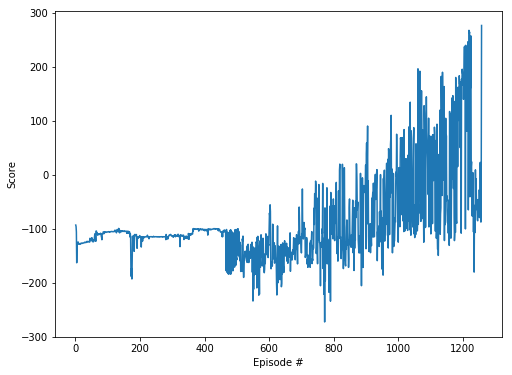

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('episodes10000v2.png')
plt.show()

In [7]:
import numpy as np

In [14]:
np.savetxt('bipedal_scores.txt', np.array(scores))

In [15]:
scores

[-92.59647762272508,
 -95.24957763123513,
 -105.2948873630939,
 -162.58186149919504,
 -128.186327895858,
 -127.92999218980161,
 -125.83208398252788,
 -123.90061337871477,
 -124.43003618026151,
 -128.16342571461325,
 -127.78695111857292,
 -128.03455230849113,
 -127.89699644212548,
 -128.16931161667156,
 -127.93294725132114,
 -128.0583919673444,
 -126.19741550715516,
 -126.15177515262366,
 -125.94092920925965,
 -126.62365864331275,
 -126.4570017501209,
 -126.45389682216943,
 -125.82223394509096,
 -125.85036944191097,
 -125.84772064594613,
 -125.88484286738559,
 -125.63379529794865,
 -124.53523473061063,
 -124.44820045550293,
 -124.62374490223453,
 -125.03831138047141,
 -124.71276237172881,
 -124.94785510802082,
 -124.31009434345489,
 -124.36170494446158,
 -122.79009308294083,
 -123.70294848946295,
 -123.39195078245302,
 -123.13954328798565,
 -123.30372535700661,
 -123.08733391673925,
 -123.83226374616599,
 -124.14137645125948,
 -124.20641416478281,
 -117.14343866302383,
 -117.55643436950

In [ ]:
np.savetxt('bipedal_hardcore_scores.txt', np.array(scores))

In [ ]:
scores